In [1]:
#default_exp core.random_variable

- [X] TODO: implement kde estimation and entropy estimation
- [X] TODO: make an abstracction for random varriable in order to bring kde to same abstractions of sample, etc...
- [ ] TODO: make an abstracction for random varriable in order to bring sklearn GMM and kde  to same abstractions of sample, etc...
- [ ] TODO: make RVArray an instance of np.array
- [ ] TODO: make RVarray access attributes for multidimensional RVarrays and return array with same size of result objects

In [ ]:
#hide
from nbdev.showdoc import *

In [4]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Meta Distributions

> Extension of SciPy rv_continuous Class, containing some useful methods for Maximum Likelihood Estimation and other distribution methods.

## imports

In [2]:
#export
from functools import partial

import scipy.stats as stats
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import QuantileTransformer

import KDEpy as kdepy

from scikit_density.utils import cos_sim_query, sample_multi_dim, ctqdm

## Helping classes

In [16]:
class DelegateEstimatorMixIn(object):
    '''
    class to make getattr method look for method in estimator object if not found in parent class.
    parent class should contain 'estimator' attribute
    '''
    def __getattr__(self,attr):
        if (attr in dir(self)) or (attr in list(self.__dict__)):
            return object.__getattribute__(self, attr)
        else:
            return object.__getattribute__(self.estimator, attr)

                    
            

## KDE Class - 

In [42]:
import awkde
import KDEpy as kdepy

class KDE(DelegateEstimatorMixIn):
    
    def __init__(self, kernel = 'gaussian', bw = 'ISJ', alpha = 0.5, implementation = 'auto'):
        self.kernel = kernel
        self.bw = bw
        self.alpha = alpha
        self.implementation = implementation
        
    def _check_X_2d(self,X):
        X = np.array(X)
        #reshape if shape == (n_samples,)
        X = X if len(X.shape) > 1 else X.reshape(-1,1)
        return X
    
    def _check_input_dims_match(self, X):
        if X.shape[-1] != self.n_dim:
            raise ValueError(f'X dimensions space should be the same size as fitted distribution ({self.n_dim}), got {X.shape[-1]} instead')
        
    def fit(self, X, y = None):                                
        X = self._check_X_2d(X)        
        #grid_interval is the min and max values for each dimension. shape (n_dim, 2 -> (min,max))
        self.grid_interval = np.array([X.min(axis = 0),X.max(axis = 0)]).T
        
        #check if n_dim is lower equal to 10
        n_dim = X.shape[-1]
        self.n_dim = n_dim
        if n_dim > 10:
            raise ValueError(f'dimension of distribution should be lower or equal to 10. got {n_dim} dimensions instead')
        
        # resolution is such that grid sampling doesn't exceeds 10000 points
        self.kde_resolution = max(2,int(10000**(1/n_dim)))
        if self.implementation == 'auto':
            #select kde implementation according to scale
            # FFT is faster but its slower to evalute due to grid evaluation which scales as a power of grid resolution
            if X.shape[0] > 300:
                # find marginal bws for multidim data
                bw = [kdepy.FFTKDE(bw = self.bw).bw(X[:,i:i+1]) for i in range(X.shape[-1])]
                self.estimator = kdepy.FFTKDE(kernel = self.kernel, bw = bw, )
            else:    
                self.estimator = awkde.GaussianKDE(glob_bw = self.bw, alpha = self.alpha, )
        
        elif self.implementation == 'adaptative':
            self.estimator = awkde.GaussianKDE(glob_bw = self.bw, alpha = self.alpha, )
        else:
            # find marginal bws for multidim data
            bw = [kdepy.FFTKDE(bw = self.bw).bw(X[:,i:i+1]) for i in range(X.shape[-1])]
            self.estimator = kdepy.FFTKDE(kernel = self.kernel, bw = bw, )
            
        self.estimator.fit(X)
        return self
    
    def evaluate(self, data):
        data = self._check_X_2d(data)
        self._check_input_dims_match(data)
        if isinstance(self.estimator, awkde.GaussianKDE):
            return self.estimator.predict(data)
        else:
            evaluate = self.estimator.evaluate(self.kde_resolution)
            #kde_values = evaluate[0]
            #kde_pdf = evaluate[1]            
            idxs = euclidean_distances(data,evaluate[0]).argmin(axis = 1)
            return evaluate[1][idxs]
        
    def predict(self, X):        
        return self.evaluate(X)
    
    def pdf(self, data):        
        return self.evaluate(data)
    
    def rvs(self, size = 1, random_state = None):        
        if isinstance(self.estimator, awkde.GaussianKDE):       
            return self.estimator.sample(n_samples = size, random_state=random_state)
        else:
            values, probas = self.estimator.evaluate(self.kde_resolution)
            sampled_idxs = np.random.choice([*range(values.shape[0])], size = size)
            return values[sampled_idxs]
    
    def sample(self, size = 1, random_state = None):
        return self.rvs(size, random_state)
    
    def entropy(self, sample_size = 100):        
        if isinstance(self.estimator, awkde.GaussianKDE):            
            return np.mean(-np.log(self.pdf(self.rvs(size = sample_size))))            
        else:
            kde_pdf = self.estimator.evaluate(self.kde_resolution)[1]
            kde_pdf = np.random.choice(kde_pdf,p = kde_pdf/kde_pdf.sum(), size = sample_size)
            return np.mean(-np.log(kde_pdf))

    
        

In [45]:
KDE().fit(np.random.randn(3000,3)).evaluate(np.random.randn(30,3))

array([0.02674598, 0.04168318, 0.01918016, 0.03108934, 0.02487211,
       0.03130068, 0.00973187, 0.0107458 , 0.0589412 , 0.00618006,
       0.00786614, 0.01627313, 0.00719818, 0.02639213, 0.01256949,
       0.01636656, 0.01648269, 0.00974099, 0.00688727, 0.0202695 ,
       0.01879039, 0.01993599, 0.00736349, 0.00472421, 0.01429046,
       0.0418637 , 0.01431491, 0.05859671, 0.02492065, 0.05292763])

## RandomVariable Class - 

In [66]:
#export

class RandomVariable():
    '''
    A container for distribution objects
    '''
    
    @classmethod
    def from_weights(cls, values, weights, n_samples = 100, **ecdf_kwargs):
        data = np.random.choice(values,size = n_samples, p = weights)
        return cls.__init__(data, **ecdf_kwargs)
    
    def __init__(self, data, verbose = False, **ecdf_kwargs):        
        self.samples = data
        self.n_dim = 1 if len(data.shape) == 1 else data.shape[-1]
        self._fitted_dists = {}
        self.log_likelihood = []
        self.verbose = False
        self.ecdf = QuantileTransformer(**ecdf_kwargs).fit(data)
        return
        
    def __getitem__(self, item):
        if item == 'best':
            try:
                item = self._best_fit_alias
            except AttributeError:
                raise AttributeError('RandomVariable object has no "best" fit yet. Fit at least one density function through fit_dist method')
        
        return self._fitted_dists[item][0]
    
    #def __repr__(self):
    #    return f'RandomVariable({str(self.samples)})'
    
    def fit_best(self, candidates = ['norm','halfnorm','lognorm']):
        #fit all and make alias for best fit
        self._fit_all(self.samples, candidates)
        return self
    
    
    def fit_dist(self, dist, **dist_kwargs):
        return self._fit_dist(self.samples,dist, **dist_kwargs)
    
    def _check_best(self):
        dists_aliases = list(self._fitted_dists)
        dists_arr = np.array([i[1] for i in self._fitted_dists.values()])
        best_fit_idx = np.argmax(dists_arr)
        self._best_fit_alias = dists_aliases[best_fit_idx]
        return
    
    def _fit_all(self, data, candidates):        
        #TODO: check for multiplicity in candidates aliases
        for candidate in ctqdm(candidates, verbose = self.verbose):
            self.fit_dist(candidate)            
        return self

    def _fit_dist(self, data, dist, **dist_kwargs):      
        '''
        fits a specified distribution through scipy.stats.rv_continuous.fit method
        '''
        alias, dist_name = self._handle_dist_names(dist)
        alias, dist_class = self._get_dist_from_name(alias, dist_name)
        if alias.lower() == 'best':
            raise ValueError('"best" cannot be an alias for a distribution. its internally assgined to the best fit dist')
        if alias != 'kde':
            if self.n_dim > 1:
                raise ValueError('rv_continuous distributions is only available for 1d distributions. Use "kde" dist instead'.)
            params = dist_class.fit(data)
            log_likelihood = np.log(np.product(dist_class.pdf(data,*params)))
            self._fitted_dists = {**self._fitted_dists, **{alias:(dist_class(*params),log_likelihood)}}
            self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
        else:
            dist = dist_class(**dist_kwargs).fit(data)
            log_likelihood = np.log(np.product(dist.pdf(data)))
            self._fitted_dists = {**self._fitted_dists, **{alias:(dist,log_likelihood)}}
            self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
        
        #update 'best' alias
        self._check_best()
        return self
    
    
    def _get_dist_from_name(self, alias, dist_name):
        '''
        handles dist_names. if str tries to get an attribute from scipy.stats accordingly
        that is also instance of scipy.stats.rv_continuous
        '''
        if isinstance(dist_name,str):        
            if isinstance(getattr(stats,dist_name), stats.rv_continuous):
                alias = dist_name
                return (alias, getattr(stats,dist_name))
            elif dist_name.lower() == 'kde':
                alias = 'kde'
                return (alias, KDE)
            else:
                raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance, not {getattr(stats,dist_name)}')

        elif isinstance(dist_name, stats.rv_continuous):
            return (alias, dist_name)
        else:
            raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance or str, not {dist_name}')
    
    def _handle_dist_names(self, candidate_value):
        '''
        checks the inputs in elements of "candidates"
        returns a named tuple
        '''
        if isinstance(candidate_value, str):
            return candidate_value, candidate_value

        elif isinstance(candidate_value, tuple):

            if not len(candidate_value) == 2:
                raise ValueError(f'candidate named tuple must be of size 2, "{candidate_value}" has size {len(candidate_value)}')

            if not isinstance(candidate_value[0], str):
                raise ValueError(f'a candidate must be a str or named tuple (alias[str],<rv_continuous intance>), alias is of type {candidate_value[0].__class__}')

            else:
                return candidate_value                
    
    def sample(self, size, dist = 'empirical', **kwargs):
        if dist == 'empirical':
            sampled_idxs = np.random.choice([*range(self.samples.shape[0])], size = size, **kwargs)
            return self.samples[sampled_idxs]    
        else:
            return self[dist].rvs(size = size, **kwargs)
    
    def cdf(self, data, dist = 'empirical'):
        if dist == 'empirical':
            return self.ecdf.transform(data)
        else:
            return self[dist].cdf(data)
    
    def pdf(self, data, dist = 'best'):
        if dist == 'empirical':
            raise ValueError('empirical quantile distribution has no pdf definition')    
        else:
            return self[dist].pdf(data)
    
    def ppf(self, data, dist = 'empirical'):
        if dist == 'empirical':
            return self.ecdf.inverse_transform(data)
        else:
            return self[dist].ppf(data)
    
    def entropy(self, data, dist = ''):
        pass
        

A RandomVariable Class facilitates the process of fitting multiple parametric distributions avalible in https://docs.scipy.org/doc/scipy/reference/stats.html from a data sample, for example:

Dist args:
(2, 0, 1)
[('norm', -112.79096260548873), ('halfnorm', -93.93208726843788), ('lognorm', -43.46212548613501)]
MLE fitted dist args:
(2.2880448573193473, 0.015806785601633944, 0.45026379536982797)


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (30). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


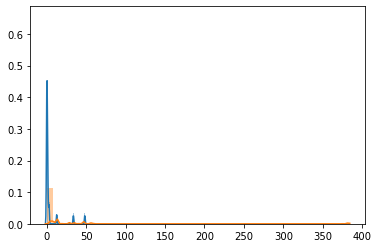

In [1859]:
import seaborn as sns
dist_args = (2,0,1)

#data = stats.lognorm.rvs(dist_args[0], loc = dist_args[1], scale = dist_args[2], size = 30)
dist = stats.lognorm(s = dist_args[0],loc = dist_args[1], scale = dist_args[2])
data = dist.rvs(size = [30,1])
rv = RandomVariable(data)
rv.fit_best(candidates = ['norm','halfnorm','lognorm'])

mle_samples = rv['best'].rvs([100,1])
#plot distributions

print('Dist args:')
print(dist_args)
print(rv.log_likelihood)
print('MLE fitted dist args:')
print(rv['best'].args)

sns.distplot(data)
sns.distplot(mle_samples)


## RVArray - 

In [1860]:
#export

class RVArray():
    '''
    An array that contains RandomVariable objects and facilitates method calls and getting attributes
    '''
    def __init__(self, data):
        ''' the constructor recieves a list of RandomVariable items'''
        self.data = np.array(data)
    
    def __getattr__(self, attr):
        attr_list = [getattr(i,attr) for i in self.data]                
        return RVArray(attr_list)      
    
    def __call__(self, *args, **kwargs):
        results = [i(*args,**kwargs) for i in self.data]
        if all([isinstance(i,np.ndarray) for i in results]):
            return np.array(results)
        else:
            return RVArray(results)
    
    def __getitem__(self, *args):

        if len(args) > 1:
            return RVArray(self.data[args])
        else:
            if args[0].__class__ == str:
                return RVArray([i[args[0]] for i in self.data])
            else:
                return self.data[args]      
    
    def __repr__(self):
        return f'RVArray({str(self.data)})'

A RVArray is a data sctructure tthat facilitates handling multiple RandomVariable objects, assessing RandomVariable methods and attributes in a vectorwise fashion

In [1861]:
rv2 = RandomVariable(mle_samples)
rv_arr = RVArray([rv,rv2])
rv_arr.fit_dist('norm')
rv_arr.sample(size = 10)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[[4.83947969e+01],
        [1.35872043e+00],
        [3.05148418e+00],
        [1.06865818e+00],
        [1.08476308e+00],
        [2.39457011e-02],
        [8.33564895e-02],
        [3.05569778e+00],
        [2.39457011e-02],
        [5.25283925e-01]],

       [[2.90117386e-01],
        [1.51204850e-01],
        [1.61314240e-02],
        [1.99814933e-01],
        [1.99814933e-01],
        [2.90117386e-01],
        [2.13775699e+00],
        [6.41298426e-01],
        [3.58064643e+01],
        [1.39416699e+01]]])

In [2600]:
#hide
# kde methods performance evaluation
from time import time
from tqdm import tqdm


n_samples = 400


dist = stats.norm(loc = 10, scale = 10)
tree_kde = [[],[]]
fft_kde = [[],[]]
adapatative_kde = [[],[]]
entropies = []
n_samples_list = []
for i in tqdm([*range(100)]):
    
    #samples = np.stack([dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),dist.rvs(n_samples),
    #               ], axis = -1)
    n_samples = max(2,10**int(i/23))
    n_samples_list.append(n_samples)
    samples = dist.rvs(n_samples)
    samples = samples if len(samples.shape) > 1 else samples.reshape(-1,1)
    n_dim = samples.shape[-1]    
    resolution = int(10000**(1/n_dim))
    
    entropies.append(dist.entropy()*n_dim)
    if 0:#resolution**n_dim > 100000:
        tic = time()
        kde = kdepy.FFTKDE(bw = 'scott')
        bw = [kde.bw(samples[:,i:i+1]) for i in range(samples.shape[-1])]        
        kde = kdepy.TreeKDE(bw = bw).fit(samples)
        evaluate = kde.evaluate(samples)
        entr = np.mean(-np.log(evaluate[1]))
        toc = time()
        tree_kde[0].append(entr)
        tree_kde[1].append(toc-tic)
        #kde_values = evaluate[0]
        #kde_pdf = evaluate[1]
    if 1:           
        tic = time()
        kde = kdepy.FFTKDE(bw = bw).fit(samples)
        evaluate = kde.evaluate(resolution)
        #kde_values = evaluate[0]
        kde_pdf = evaluate[1]
        #idxs = euclidean_distances(kde.data,kde_values).argmin(axis = 1)
        #kde_pdf = kde_pdf[idxs]
        #kde_values = kde_values[idxs]
        kde_pdf = np.random.choice(kde_pdf,p = kde_pdf/kde_pdf.sum(), size = 1000)
        entr = np.mean(-np.log(kde_pdf))
        toc = time()
        fft_kde[0].append(entr)
        fft_kde[1].append(toc-tic)
    if 1:
        tic = time()
        g = GaussianKDE(glob_bw = 'scott',alpha = 0.5)
        g.fit(samples)
        entr = np.mean(-np.log(g.predict(g.sample(100))))        
        toc = time()
        adapatative_kde[0].append(entr)
        adapatative_kde[1].append(toc-tic)
        

#dist.entropy(), np.mean(-np.log(kde_pdf)/n_dim), resolution

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.69it/s]


3.721523626198719

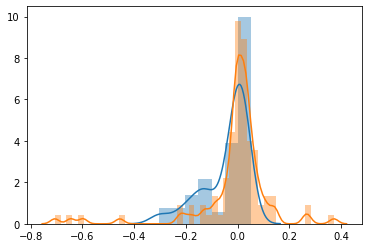

In [2601]:
#hide

#sns.distplot((np.array(tree_kde[0]) - np.array(entropies))/np.array(entropies))
sns.distplot((np.array(fft_kde[0]) - np.array(entropies))/np.array(entropies))
sns.distplot((np.array(adapatative_kde[0]) - np.array(entropies))/np.array(entropies))
np.array(entropies).mean()

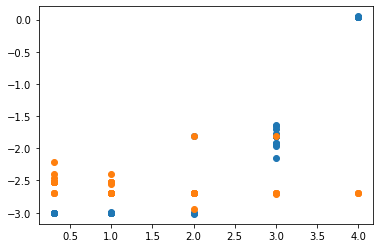

In [2602]:
#hide

#sns.distplot(np.log10(np.array(tree_kde[1])[np.array(tree_kde[1])>0]))
plt.scatter(np.log10(np.array(n_samples_list))[np.array(adapatative_kde[1])>0],np.log10(np.array(adapatative_kde[1])[np.array(adapatative_kde[1])>0]))
plt.scatter(np.log10(np.array(n_samples_list))[np.array(fft_kde[1])>0],np.log10(np.array(fft_kde[1])[np.array(fft_kde[1])>0]))
#sns.distplot(np.log10(np.array(fft_kde[1])[np.array(fft_kde[1])>0]))


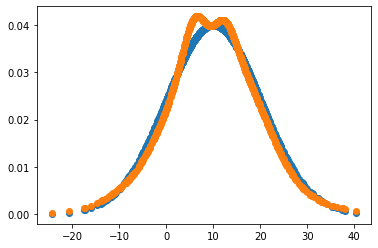

In [2504]:
#hide
if np.array(samples).shape[1] == 1:
    plt.scatter(samples[:,0],dist.pdf(samples))
    #plt.scatter(samples[:,0],kde.evaluate(samples), color = 'r')
    plt.scatter(samples[:,0],g.predict(samples))